In [1]:
# importing necessary Python libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
#import plotly.figure_factory as ff

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
# from multiscorer import MultiScorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
# import xgboost as xgb
import time 

In [2]:
# Loading the data
# We are going to do product related categorization and/or predictions
# For this we need : Customers table, Orders table, Order_Items table, Products table, Product translation table
customers_df = pd.read_csv('Resources/olist_customers_dataset.csv')
orders_df = pd.read_csv('Resources/olist_orders_dataset.csv')
order_items_df = pd.read_csv('Resources/olist_order_items_dataset.csv')
products_df = pd.read_csv('Resources/olist_products_dataset.csv')
products_translation_df = pd.read_csv('Resources/product_category_name_translation.csv')
order_payments_df = pd.read_csv('Resources/olist_order_payments_dataset.csv')
reviews_df = pd.read_csv('Resources/olist_order_reviews_dataset.csv')

**Merging the following csvs**
1. Both products related csvs to get one products table
2. Merge products table with order_items on product_id
3. Merge order_items with orders to get customer_id
4. Merge with order_reviews to get review ratings
5. Lastly merge above with customers_df to get customers related info

In [3]:
products_combined_df = pd.merge(products_df, products_translation_df, on="product_category_name")
products_combined_df.head()
products_combined_df.drop("product_category_name", axis=1, inplace=True)
products_combined_df[['product_category_name_english']] = products_combined_df[['product_category_name_english']].astype(str)


**Merge with order_items_df**


In [4]:
pdts_items_df = pd.merge(products_combined_df, order_items_df, on="product_id")
pdts_items_df.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,048cc42e03ca8d43c729adf6962cb348,1,7040e82f899a04d1b434b795a43b4617,2017-11-23 21:31:31,16.90,7.78
2,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,5fa78e91b5cb84b6a8ccc42733f95742,1,7040e82f899a04d1b434b795a43b4617,2017-12-14 16:33:14,16.90,7.78
3,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,1,fe2032dab1a61af8794248c8196565c9,2017-08-03 09:50:14,339.00,17.13
4,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,7b13c77c64a9a956500cbf1a9a23798d,1,7178f9f4dd81dcef02f62acdf8151e01,2018-05-30 10:38:35,275.00,23.48


**Merge items with reviews_df**

In [5]:
pdts_reviews_df = pd.merge(pdts_items_df, reviews_df, on="order_id")
pdts_reviews_df

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,...,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,...,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,d71da8fd8c6e3adef26be965f065b8a1,5,Vale a pena,Super adooorei o delineador ele é bem preto e ...,2018-04-28 00:00:00,2018-05-04 00:55:02
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,048cc42e03ca8d43c729adf6962cb348,...,7040e82f899a04d1b434b795a43b4617,2017-11-23 21:31:31,16.90,7.78,0d953190c8ed55747f7b7ad3af2885e3,5,NaN,O produto que chegou é mais bonito do que eu e...,2017-11-24 00:00:00,2017-11-24 18:34:45
2,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,5fa78e91b5cb84b6a8ccc42733f95742,...,7040e82f899a04d1b434b795a43b4617,2017-12-14 16:33:14,16.90,7.78,8e762254a11ad4292ec8fb6586c681cf,2,NaN,NaN,2017-12-14 00:00:00,2017-12-17 02:57:05
3,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,...,fe2032dab1a61af8794248c8196565c9,2017-08-03 09:50:14,339.00,17.13,de311dfd0cf46c629921db407a7d87e9,5,NaN,ótimo produto e ótima loja para comprar pelo s...,2017-08-09 00:00:00,2017-08-09 19:30:09
4,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,7b13c77c64a9a956500cbf1a9a23798d,...,7178f9f4dd81dcef02f62acdf8151e01,2018-05-30 10:38:35,275.00,23.48,097582b6b0630f5cb1a409c223c406dc,3,Não passou confiança,"O fornecedor e a nf é de São Paulo, o produto ...",2018-06-07 00:00:00,2018-06-12 13:44:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110745,1dceebcc5f23c02ea23e16d5bedca000,47.0,117.0,2.0,550.0,35.0,15.0,25.0,cds_dvds_musicals,7ed69fbc79fbda50e09caa9c127026e5,...,4e922959ae960d389249c378d1c939f5,2018-05-02 11:54:43,65.00,52.58,fe178e554333a4aa1ebd413e67d1419f,5,OTIMO,OTIMO,2018-05-10 00:00:00,2018-05-11 13:58:25
110746,1dceebcc5f23c02ea23e16d5bedca000,47.0,117.0,2.0,550.0,35.0,15.0,25.0,cds_dvds_musicals,9c782cb7854e5dfa91927cfca8949eb8,...,4e922959ae960d389249c378d1c939f5,2017-07-19 11:35:22,45.00,16.11,bc3edd7b44020db68f771461727308e7,5,NaN,NaN,2017-07-19 00:00:00,2017-07-21 23:28:33
110747,1dceebcc5f23c02ea23e16d5bedca000,47.0,117.0,2.0,550.0,35.0,15.0,25.0,cds_dvds_musicals,cea54c1853c864ab36cea3ef732d7191,...,4e922959ae960d389249c378d1c939f5,2017-11-14 11:50:17,65.00,9.94,c264f18d933db39d774ec36addb9fd66,5,NaN,NaN,2017-11-15 00:00:00,2017-11-16 11:26:14
110748,1dceebcc5f23c02ea23e16d5bedca000,47.0,117.0,2.0,550.0,35.0,15.0,25.0,cds_dvds_musicals,d4e8d3bb5e3673ed68ac154fe86de946,...,4e922959ae960d389249c378d1c939f5,2017-11-03 11:29:30,45.00,16.11,d363709f221521f9a0e43945480e1ace,5,NaN,NaN,2017-11-04 00:00:00,2017-11-06 14:54:54


**Merge products_reviews with orders table**

In [6]:
pdts_orders_df = pd.merge(pdts_reviews_df, orders_df, on="order_id")
pdts_orders_df.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,...,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,...,Super adooorei o delineador ele é bem preto e ...,2018-04-28 00:00:00,2018-05-04 00:55:02,f8a3e963a310aa58b60a5b1fed5bceb5,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,2018-04-25 17:01:00,2018-04-27 16:42:17,2018-05-09 00:00:00
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,048cc42e03ca8d43c729adf6962cb348,...,O produto que chegou é mais bonito do que eu e...,2017-11-24 00:00:00,2017-11-24 18:34:45,12a2c614dfc8926e793516b1638c7471,delivered,2017-11-16 21:28:00,2017-11-17 21:35:39,2017-11-21 22:14:50,2017-11-23 15:39:38,2017-11-29 00:00:00
2,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,5fa78e91b5cb84b6a8ccc42733f95742,...,NaN,2017-12-14 00:00:00,2017-12-17 02:57:05,c15eed3881abc9e06763c989679c5094,delivered,2017-11-30 01:51:23,2017-12-08 16:33:14,2017-12-09 00:53:08,2017-12-13 20:52:32,2017-12-18 00:00:00
3,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,...,ótimo produto e ótima loja para comprar pelo s...,2017-08-09 00:00:00,2017-08-09 19:30:09,6d699e3ab0fd90fffb3d1379d937de77,delivered,2017-07-28 09:34:29,2017-07-28 09:50:14,2017-07-28 21:42:11,2017-08-08 16:03:45,2017-08-21 00:00:00
4,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,7b13c77c64a9a956500cbf1a9a23798d,...,"O fornecedor e a nf é de São Paulo, o produto ...",2018-06-07 00:00:00,2018-06-12 13:44:18,45d942b1af5529f8990f27848a40e645,delivered,2018-05-17 09:24:18,2018-05-17 10:38:35,2018-06-01 09:04:00,2018-06-07 19:12:50,2018-06-05 00:00:00


**Merge above dataframe with customers table**

In [7]:
pdts_customers_df = pd.merge(pdts_orders_df, customers_df, on="customer_id")
pdts_customers_df.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,...,delivered,2018-04-24 16:16:53,2018-04-24 19:04:19,2018-04-25 17:01:00,2018-04-27 16:42:17,2018-05-09 00:00:00,b1a1199364a4a7fe27c4486ab63f550d,13848,mogi-guacu,SP
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,048cc42e03ca8d43c729adf6962cb348,...,delivered,2017-11-16 21:28:00,2017-11-17 21:35:39,2017-11-21 22:14:50,2017-11-23 15:39:38,2017-11-29 00:00:00,7139ee1d2ad919a82b6e68a29582264e,6519,santana de parnaiba,SP
2,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,5fa78e91b5cb84b6a8ccc42733f95742,...,delivered,2017-11-30 01:51:23,2017-12-08 16:33:14,2017-12-09 00:53:08,2017-12-13 20:52:32,2017-12-18 00:00:00,48d6d950c0aba132537fc335c0c56e01,5893,sao paulo,SP
3,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,24b1c4d88fdb7a2dc87f8ecc7d8f47f1,...,delivered,2017-07-28 09:34:29,2017-07-28 09:50:14,2017-07-28 21:42:11,2017-08-08 16:03:45,2017-08-21 00:00:00,0b3dc7efaafb0cf78a4796d42fa8d74c,22410,rio de janeiro,RJ
4,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,7b13c77c64a9a956500cbf1a9a23798d,...,delivered,2018-05-17 09:24:18,2018-05-17 10:38:35,2018-06-01 09:04:00,2018-06-07 19:12:50,2018-06-05 00:00:00,abd7e9db219836e58c3fca4965dd14e5,1042,sao paulo,SP


**Prepare a list of transactions that customer has made**

In [8]:
#Filter out all the customers with multiple products purchased into a new dataframe
transactions_df = pdts_customers_df[["customer_id", "customer_unique_id", "product_category_name_english"]]
transactions_df

,customer_id,customer_unique_id,product_category_name_english
0,f8a3e963a310aa58b60a5b1fed5bceb5,b1a1199364a4a7fe27c4486ab63f550d,perfumery
1,12a2c614dfc8926e793516b1638c7471,7139ee1d2ad919a82b6e68a29582264e,perfumery
2,c15eed3881abc9e06763c989679c5094,48d6d950c0aba132537fc335c0c56e01,perfumery
3,6d699e3ab0fd90fffb3d1379d937de77,0b3dc7efaafb0cf78a4796d42fa8d74c,perfumery
4,45d942b1af5529f8990f27848a40e645,abd7e9db219836e58c3fca4965dd14e5,perfumery
...,...,...,...
110745,1ce59f480a5fbb7054f9f8e59c577858,8cae259d6dffc5c760fe04bb485d2b6b,cds_dvds_musicals
110746,9cedc9b5217be6c8cb89e73ce5390c1e,f324449067166ef57fea2d94d4cab768,cds_dvds_musicals
110747,c09801227c7f48130b33a8ddb9d91660,882023c0b40dc2130beea608b1196262,cds_dvds_musicals
110748,63155d2512ff588adce41f3fb43f6a6d,f55304849386dd15f067691bd606d75a,cds_dvds_musicals


In [9]:
customer_purchase_pdts_dict = pdts_customers_df.groupby("customer_unique_id")["product_category_name_english"].unique().to_dict()
customer_purchase_pdts_dict


{'0000366f3b9a7992bf8c76cfdf3221e2': array(['bed_bath_table'], dtype=object),
 '0000b849f77a49e4a4ce2b2a4ca5be3f': array(['health_beauty'], dtype=object),
 '0000f46a3911fa3c0805444483337064': array(['stationery'], dtype=object),
 '0000f6ccb0745a6a4b88665a16c9f078': array(['telephony'], dtype=object),
 '0004aac84e0df4da2b147fca70cf8255': array(['telephony'], dtype=object),
 '0004bd2a26a76fe21f786e4fbd80607f': array(['garden_tools'], dtype=object),
 '00050ab1314c0e55a6ca13cf7181fecf': array(['telephony'], dtype=object),
 '00053a61a98854899e70ed204dd4bafe': array(['sports_leisure'], dtype=object),
 '0005e1862207bf6ccc02e4228effd9a0': array(['fashion_bags_accessories'], dtype=object),
 '0005ef4cd20d2893f0d9fbd94d3c0d97': array(['sports_leisure'], dtype=object),
 '0006fdc98a402fceb4eb0ee528f6a8d4': array(['bed_bath_table'], dtype=object),
 '00082cbe03e478190aadbea78542e933': array(['luggage_accessories'], dtype=object),
 '00090324bbad0e9342388303bb71ba0a': array(['bed_bath_table'], dtype=ob

In [72]:
customer_purchase_pdts_list = pdts_customers_df.groupby("customer_unique_id")["product_category_name_english"].unique().to_list()
customer_purchase_pdts_list


[array(['bed_bath_table'], dtype=object),
 array(['health_beauty'], dtype=object),
 array(['stationery'], dtype=object),
 array(['telephony'], dtype=object),
 array(['telephony'], dtype=object),
 array(['garden_tools'], dtype=object),
 array(['telephony'], dtype=object),
 array(['sports_leisure'], dtype=object),
 array(['fashion_bags_accessories'], dtype=object),
 array(['sports_leisure'], dtype=object),
 array(['bed_bath_table'], dtype=object),
 array(['luggage_accessories'], dtype=object),
 array(['bed_bath_table'], dtype=object),
 array(['computers_accessories'], dtype=object),
 array(['health_beauty'], dtype=object),
 array(['fashion_bags_accessories'], dtype=object),
 array(['bed_bath_table'], dtype=object),
 array(['telephony'], dtype=object),
 array(['bed_bath_table'], dtype=object),
 array(['fashion_underwear_beach'], dtype=object),
 array(['home_appliances'], dtype=object),
 array(['computers_accessories'], dtype=object),
 array(['musical_instruments', 'toys'], dtype=object),


In [74]:
counts = [len(transaction) for transaction in customer_purchase_pdts_list]
np.median(counts)

1.0

In [75]:
np.max(counts)

5

In [76]:
from mlxtend.preprocessing import TransactionEncoder
# Instantiate an encoder.
encoder = TransactionEncoder()

# Fit encoder to list of lists.
encoder.fit(customer_purchase_pdts_list)

# Transform lists into one-hot encoded array.
onehot = encoder.transform(customer_purchase_pdts_list)
# Convert array to pandas DataFrame.
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
# Print header.
onehot.head()

,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
0,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [77]:
onehot.mean(axis=0)

agro_industry_and_commerce    0.001938
air_conditioning              0.002645
art                           0.002141
arts_and_craftmanship         0.000225
audio                         0.003705
                                ...   
stationery                    0.024412
tablets_printing_image        0.000824
telephony                     0.044145
toys                          0.040804
watches_gifts                 0.058878
Length: 71, dtype: float64

In [78]:
onehot.sum(axis=1).value_counts()

1    91210
2     2062
3      108
4       12
5        5
dtype: int64

In [79]:
from mlxtend.frequent_patterns import apriori

#applying the apriori algorithm
frequent_itemsets = apriori(onehot, min_support = 0.001, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.001938,(agro_industry_and_commerce)
1,0.002645,(air_conditioning)
2,0.002141,(art)
3,0.003705,(audio)
4,0.041040,(auto)
5,0.030354,(baby)
6,0.096866,(bed_bath_table)
7,0.005375,(books_general_interest)
8,0.002741,(books_technical)
9,0.001349,(christmas_supplies)


In [80]:
# Apply apriori algorithm to data with a two-item limit.
frequent_itemsets = apriori(onehot, min_support = 0.00005, max_len = 2, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.001938,(agro_industry_and_commerce)
1,0.002645,(air_conditioning)
2,0.002141,(art)
3,0.000225,(arts_and_craftmanship)
4,0.003705,(audio)
...,...,...
204,0.000214,"(sports_leisure, watches_gifts)"
205,0.000139,"(toys, stationery)"
206,0.000064,"(watches_gifts, stationery)"
207,0.000096,"(telephony, watches_gifts)"


In [81]:
from mlxtend.frequent_patterns import association_rules

# Recover association rules using support and a minimum threshold of 0.0001.
rules = association_rules(frequent_itemsets, metric = 'support', min_threshold = 0.0001)

# Print rules header.
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(auto),(bed_bath_table),0.041040,0.096866,0.000161,0.003913,0.040400,-0.003815,0.906682
1,(bed_bath_table),(auto),0.096866,0.041040,0.000161,0.001658,0.040400,-0.003815,0.960553
2,(auto),(garden_tools),0.041040,0.037121,0.000118,0.002870,0.077310,-0.001406,0.965650
3,(garden_tools),(auto),0.037121,0.041040,0.000118,0.003173,0.077310,-0.001406,0.962012
4,(auto),(telephony),0.041040,0.044145,0.000107,0.002609,0.059099,-0.001705,0.958355
...,...,...,...,...,...,...,...,...,...
129,(watches_gifts),(sports_leisure),0.058878,0.079949,0.000214,0.003637,0.045492,-0.004493,0.923409
130,(toys),(stationery),0.040804,0.024412,0.000139,0.003411,0.139734,-0.000857,0.978927
131,(stationery),(toys),0.024412,0.040804,0.000139,0.005702,0.139734,-0.000857,0.964696
132,(toys),(watches_gifts),0.040804,0.058878,0.000107,0.002624,0.044567,-0.002295,0.943598


In [82]:
# Recover association rules using confidence threshold of 0.01.
rules = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = 0.01)

# Print rules.
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(art),(furniture_decor),0.002141,0.067111,0.000054,0.025000,0.372515,-0.000090,0.956809
1,(audio),(watches_gifts),0.003705,0.058878,0.000086,0.023121,0.392702,-0.000132,0.963397
2,(baby),(bed_bath_table),0.030354,0.096866,0.000396,0.013051,0.134734,-0.002544,0.915077
3,(baby),(cool_stuff),0.030354,0.038352,0.000332,0.010935,0.285112,-0.000832,0.972279
4,(furniture_decor),(bed_bath_table),0.067111,0.096866,0.001638,0.024410,0.251994,-0.004863,0.925731
5,(bed_bath_table),(furniture_decor),0.096866,0.067111,0.001638,0.016912,0.251994,-0.004863,0.948937
6,(furniture_living_room),(bed_bath_table),0.004390,0.096866,0.000096,0.021951,0.226614,-0.000329,0.923404
7,(home_confort),(bed_bath_table),0.004219,0.096866,0.000578,0.137056,1.414900,0.000170,1.046573
8,(housewares),(bed_bath_table),0.061897,0.096866,0.000717,0.011590,0.119647,-0.005278,0.913724
9,(kitchen_dining_laundry_garden_furniture),(bed_bath_table),0.002623,0.096866,0.000054,0.020408,0.210684,-0.000201,0.921949


In [10]:
transactions_df = pd.DataFrame(customer_purchase_pdts_dict.values())
transactions_df

,0,1,2,3,4
0,bed_bath_table,None,None,None,None
1,health_beauty,None,None,None,None
2,stationery,None,None,None,None
3,telephony,None,None,None,None
4,telephony,None,None,None,None
...,...,...,...,...,...
93392,health_beauty,None,None,None,None
93393,baby,None,None,None,None
93394,auto,None,None,None,None
93395,watches_gifts,None,None,None,None


In [83]:
# Sort the association rules by lift score
association_results_sorted = rules.sort_values(by='lift', ascending=False)


In [84]:
# Select the top N rules with highest lift score
N = 10
selected_rules = association_results_sorted.head(N)

In [87]:
selected_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(home_confort),(bed_bath_table),0.004219,0.096866,0.000578,0.137056,1.414900,0.000170,1.046573
10,(construction_tools_lights),(furniture_decor),0.002580,0.067111,0.000193,0.074689,1.112908,0.000020,1.008189
23,(furniture_living_room),(office_furniture),0.004390,0.013427,0.000054,0.012195,0.908284,-0.000005,0.998753
20,(home_construction),(furniture_decor),0.005204,0.067111,0.000203,0.039095,0.582534,-0.000146,0.970843
24,(home_construction),(garden_tools),0.005204,0.037121,0.000107,0.020576,0.554297,-0.000086,0.983107
17,(furniture_living_room),(furniture_decor),0.004390,0.067111,0.000118,0.026829,0.399772,-0.000177,0.958607
1,(audio),(watches_gifts),0.003705,0.058878,0.000086,0.023121,0.392702,-0.000132,0.963397
0,(art),(furniture_decor),0.002141,0.067111,0.000054,0.025000,0.372515,-0.000090,0.956809
19,(home_confort),(furniture_decor),0.004219,0.067111,0.000096,0.022843,0.340369,-0.000187,0.954696
14,(food),(perfumery),0.004722,0.033320,0.000054,0.011338,0.340271,-0.000104,0.977766


In [85]:
# Extract the antecedent items from the selected rules
recommendations = []
for antecedents, consequents, confidence, lift in selected_rules[['antecedents', 'consequents', 'confidence', 'lift']].values:
    antecedents = list(antecedents)
    recommendations.extend(antecedents)

# Remove duplicates and convert to a set
recommendations = list(set(recommendations))

# Provide the recommendations for the target item
print("Recommended items:", recommendations)

Recommended items: ['home_construction', 'audio', 'home_confort', 'art', 'construction_tools_lights', 'food', 'furniture_living_room']


In [12]:
#!pip install apyori

<AxesSubplot: xlabel='leverage', ylabel='confidence'>

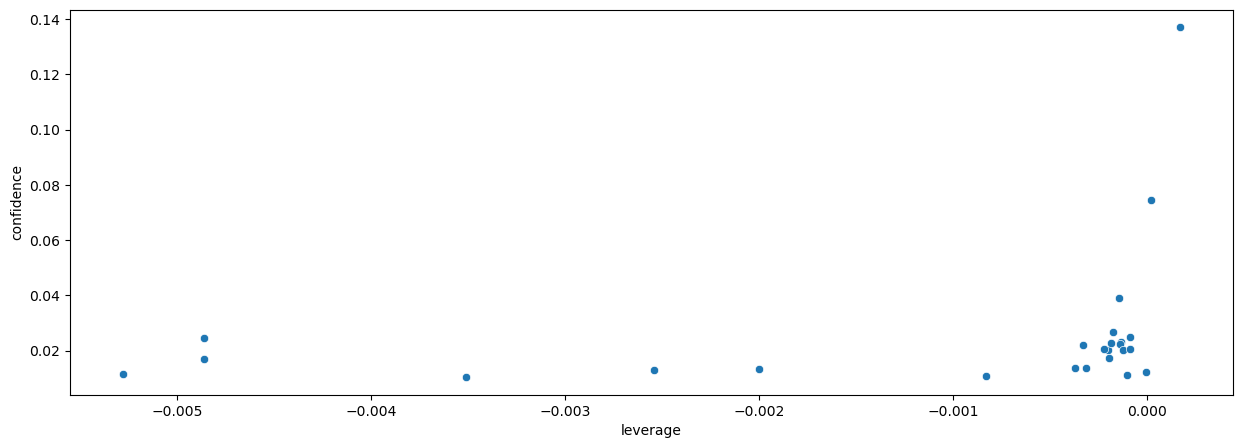

In [86]:
# Plot leverage against confidence.
plt.figure(figsize=(15,5))
sns.scatterplot(x="leverage", y="confidence", data=rules)